<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219

Intersemestral 2020

## Proyecto lenguaje de señas

### Integrantes:
* Deisy Tatiana Macias
* Dayana Romero
* Juan José Villegas
* Juan Sebastián Méndez

# 0. Toma de datos

Para la toma de datos, se hizo un programa en nodeJS que utiliza el modelo "handpose" de media pipe con tensor flow. Este programa nos permite, por medio de la cámara del computador, tomar las coordenadas de todos los _landmarks_ de la mano (más detalles en el diccionario), siendo mostradas en un cuadro de texto que luego era copiado y pegado a un archivo de excel. El código fuente está en el siguiente repositorio: https://github.com/jjr2040/ml-sign-language.

<img src="./Images/TomaDatos.png" width=600px>

## Proceso de adquisición de datos

1. Con el programa abierto y listo para la adquisición, el usuario hace la seña correspondiente.
1. Una vez en posición, se oprime el botón "Record". Este empieza un proceso de adquisición de coordenadas que dura 5 segundos.
1. Una vez finalizados los cinco segundos, tenemos resultados en un área de texto que luego copiamos y pegamos en nuestro archivo de excel.

_Nota: La cantidad de datos por cada muestra de cinco segundos varía dependiendo de varios factores._

* _Los fps (frames por segundo) que logra la máquina en la que ejecuta el programa (ejemplo, 11 fps en la imagen anterior). El programa genera una fila de datos por cada frame._
* _La iluminación y otro factores que ayudan a reconocer mejor el patrón analizado. Esto debido a que se configuró para que el sistema imprimiera una fila de datos si el modelo usado tenia una certeza del 99% de que lo analizado es efectivamente una mano._

_Con esto en mente, el programa genera de 20 a 40 filas por cada muestra de 5 segundos._

## Señas a reconocer

### Número 0

<img src="./Images/Cero.png" >

### Número 1

<img src="./Images/Uno.png" >
<img src="./Images/Uno_f.png" >

### Número 2

<img src="./Images/Dos.png" >

### Número 3

<img src="./Images/Tres.png" >

### Número 4

<img src="./Images/Cuatro.png" >

### Número 5

<img src="./Images/Cinco.png" >

### Número 6

<img src="./Images/Seis.png" >

### Número 7

<img src="./Images/Siete.png" >

### Número 8

<img src="./Images/Ocho.png" >

### Número 9

<img src="./Images/Nueve.png" >

### Número 10

<img src="./Images/Diez.png" >

# 1. Importando las librerias requeridas

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
from pandas_profiling import ProfileReport

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 2. Perfilamiento y entendimiento de los datos

<img src="./Images/Landmarks.png" >

Los datos tal como vienen del programa nos arroja tres coordenadas por cada uno de los landmarks en donde la coordenada x=0 y y=0 son la esquina abajo izquierda de la imágen. El tamaño de la imágen es fija a 640x500 pixeles. Así nuestro rango para la coordenada x y y es de 0 <= x <= 640 y 0 <= y <= 500. La coordenada cero es relativa a un punto intermedio en la pantalla (que se vean todos los puntos centrados en pantalla). A medida que la mano se acerca a la cámara obtenemos valores positivos, y si se aleja nos arroja valores negativos.

In [2]:
diccionario = pd.read_csv('./data/diccionario.csv', encoding = "UTF-8")
data = pd.read_csv('./data/datos.csv', encoding = "UTF-8")

In [3]:
profile = ProfileReport(data)
profile.to_file("profile_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Se sacan los histogramas de las variables para ver cómo están distribuídas y encontrar posibilidades de mejora, tranformación y tratamientos de los datos 

array([[<AxesSubplot:title={'center':'clase'}>,
        <AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x1'}>,
        <AxesSubplot:title={'center':'x10'}>,
        <AxesSubplot:title={'center':'x11'}>,
        <AxesSubplot:title={'center':'x12'}>,
        <AxesSubplot:title={'center':'x13'}>,
        <AxesSubplot:title={'center':'x14'}>],
       [<AxesSubplot:title={'center':'x15'}>,
        <AxesSubplot:title={'center':'x16'}>,
        <AxesSubplot:title={'center':'x17'}>,
        <AxesSubplot:title={'center':'x18'}>,
        <AxesSubplot:title={'center':'x19'}>,
        <AxesSubplot:title={'center':'x2'}>,
        <AxesSubplot:title={'center':'x20'}>,
        <AxesSubplot:title={'center':'x3'}>],
       [<AxesSubplot:title={'center':'x4'}>,
        <AxesSubplot:title={'center':'x5'}>,
        <AxesSubplot:title={'center':'x6'}>,
        <AxesSubplot:title={'center':'x7'}>,
        <AxesSubplot:title={'center':'x8'}>,
        <AxesSubplot:title={'center':'x

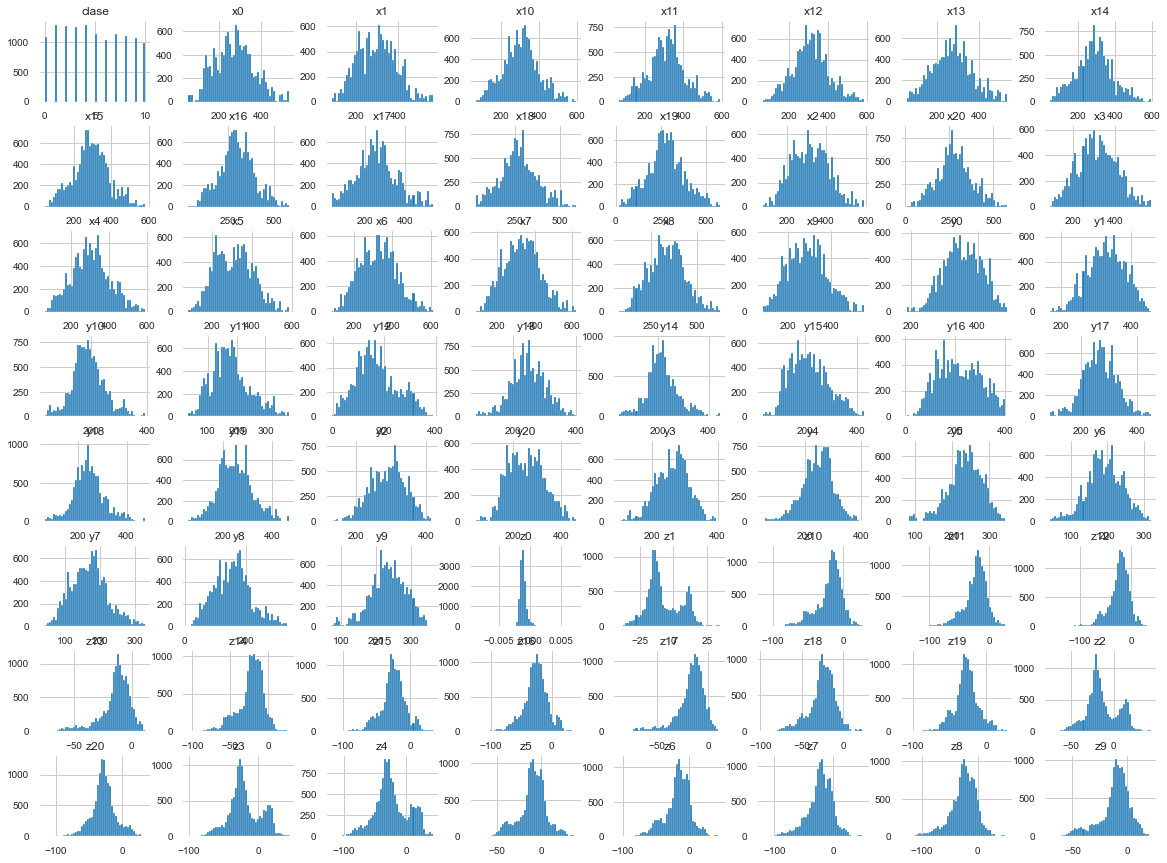

In [4]:
data.hist(bins=50, figsize=(20, 15))

Podemos ver que no hay una variable que valga la pena quitar o tratar de alguna manera en especial. Podríamos standarizar o escalar sus valores pero vamos a intentar primero sin hacerlo para ver qué resultado optenemos.

# 3. Limpieza y preparación de datos

## 3.1 Limpieza de datos

Se considera que no se debe eliminar ninguna columna, porque los datos fueron tomados de una imagen y estos representan coordenadas que son necesarias en su completitud para determinar el número. Debido a esto, no consideramos aplicable un estudio de correlación. 

## 3.2 Preparación de datos

Ya que tenemos pocos datos, utilizamos una función que crea replicas de nuestro archivo de entrada agregando ruido gaussiano a cada una de las coordenadas. Con esto logramos aumentar la cantidad de datos.

In [5]:
def augment_data(data, augmentation_factor):
    noise_dataset = pd.DataFrame(columns=data.columns)
    mu, sigma = 0, 1.5
    X, y = data.drop(['clase'], axis=1), data['clase']
    for iteration in range(augmentation_factor):
        noise = np.random.normal(mu, sigma, X.shape)
        signal = X + noise
        signal['clase'] = y
        noise_dataset = noise_dataset.append(signal, ignore_index=True)
        
    return noise_dataset

In [6]:
data_generated = augment_data(data, 2)
data_augmented = data.append(data_generated)

X, y = data_augmented.drop(['clase'], axis=1), data_augmented['clase']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=33)

Ya que las coordenadas X y Y están dadas en número de pixeles, las normalizamos y escalamos para que no dependan del tamaño de la imagen.

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train_ready = scaler.fit(X_train).transform(X_train)
X_test_ready = scaler.fit(X_test).transform(X_test)

y_train_1 = y_train.astype('int')
y_test_1 = y_test.astype('int')
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

# 4. Modelamiento

Se implementaron varios algoritmos para comparar los niveles de rendimiento y escoger los algoritmos que mejor se adaptan al problema.

## 4.1. Red neuronal (MLP)

In [8]:
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]
n_output = 11
tf.keras.backend.set_floatx('float64')

In [9]:
def build_model(n_hidden=1, n_neurons_1 = 100, n_neurons_2 = 100, dropout = 0.1, activation_hidden = 'relu', learning_rate=3e-3):
    mlp = Sequential(name='lab_6_mlp')
    first = True

    for layer in range(n_hidden):
        if first:
            mlp.add(Dense(n_neurons_1, activation=activation_hidden, name=f'hidden_layer_{layer}'))
            first = False
        else:
            mlp.add(Dense(n_neurons_2, activation=activation_hidden, name=f'hidden_layer_{layer}'))
    
    mlp.add(Dropout(dropout,name=f'dropout_layer_{dropout}'))
    mlp.add(Dense(n_output, activation='sigmoid', name= 'output_layer'))

    sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    mlp.compile(loss='categorical_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])
    
    return mlp

# Modelo que utiliza el GridSearch
modelCV = KerasClassifier(build_fn=build_model, epochs=20, batch_size=32, verbose=1,shuffle = True)

In [10]:
param_grid = dict(n_hidden = [1,2],
                  n_neurons_1 = [10, 30, 50, 100, 500, 1000],
                  n_neurons_2 = [10, 30, 50, 100, 500, 1000],
                  dropout = [0.1,0.2,0.3],
                  activation_hidden = ['relu','sigmoid'],
                  learning_rate = [0.03, 0.1, 0.3]
                  )

grid = RandomizedSearchCV(modelCV, param_grid, verbose=1, cv = 3, n_iter=10, random_state=20)
grid.fit(X_train_ready, y_train, callbacks=callbacks)

mlp_model = grid.best_estimator_
print(grid.best_params_)
print('Best score: ',grid.best_score_)
print(mlp_model)
mlp_model.model.summary()

step - loss: 0.4863 - accuracy: 0.8301
319/319 [==============================] - 0s 1ms/step - loss: 0.4146 - accuracy: 0.8630
Epoch 1/20
638/638 [==============================] - 1s 1ms/step - loss: 2.4007 - accuracy: 0.1038
Epoch 2/20
638/638 [==============================] - 1s 1ms/step - loss: 2.3875 - accuracy: 0.1062
Epoch 3/20
638/638 [==============================] - 1s 1ms/step - loss: 2.3650 - accuracy: 0.1161
Epoch 4/20
638/638 [==============================] - 1s 1ms/step - loss: 2.2531 - accuracy: 0.1847
Epoch 5/20
638/638 [==============================] - 1s 1ms/step - loss: 2.0352 - accuracy: 0.2590
Epoch 6/20
638/638 [==============================] - 1s 1ms/step - loss: 1.7854 - accuracy: 0.3316
Epoch 7/20
638/638 [==============================] - 1s 1ms/step - loss: 1.5120 - accuracy: 0.4266
Epoch 8/20
638/638 [==============================] - 1s 1ms/step - loss: 1.2621 - accuracy: 0.5196
Epoch 9/20
638/638 [==============================] - 1s 1ms/step - loss

## 4.2 Näive Bayes

In [11]:
NB = MultinomialNB().fit(X_train_ready,y_train_1)
NB

MultinomialNB()

## 4.3 SVM

In [12]:
parametros = {'gamma':[0.005, 5, 10],'C': [5e3, 1e4, 5e4]}

GridSearchCV(SVC(kernel='rbf'), param_grid=parametros).fit(X_train_ready, y_train_1).best_estimator_

SVC(C=5000.0, gamma=5)

In [13]:
svc = SVC(kernel='rbf', gamma=5, C=5000, decision_function_shape='ovr')
svc.fit(X_train_ready, y_train_1.ravel())

SVC(C=5000, gamma=5)

## 4.3 Random Forest

In [14]:
random_forest_clf = RandomForestClassifier(n_jobs=-1)

In [15]:
random_forest_clf.fit(X_train_ready, y_train)

RandomForestClassifier(n_jobs=-1)

## 4.3 SGD Classifier

In [16]:
sgd_clf = SGDClassifier(n_jobs=-1, early_stopping=True, verbose=20)

In [17]:
param_grid = {
    'alpha': [1E-4, 1E-2, 1E-1, 1, 1E1],
    'max_iter': [1000, 10000, 30000]
}

grid_sgd_clf = GridSearchCV(sgd_clf, param_grid)
%time grid_sgd_clf.fit(X_train_ready, y_train_1)
grid_sgd_clf.best_params_

ss: 0.163009Norm: 0.06, NNZs: 63, Bias: -0.772600, T: 110190, Avg. loss: 0.155490
Total training time: 0.09 seconds.

Total training time: 0.09 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.791670, T: 110190, Avg. loss: 0.144826
Total training time: 0.07 seconds.
-- Epoch 6
-- Epoch 6-- Epoch 6

Norm: 0.06, NNZs: 63, Bias: -0.775511, T: 132228, Avg. loss: 0.155406
Total training time: 0.10 seconds.
Norm: 0.05, NNZs: 63, Bias: -0.794680, T: 132228, Avg. loss: 0.144690Norm: 0.06, NNZs: 63, Bias: -0.786051, T: 132228, Avg. loss: 0.162950
Total training time: 0.08 seconds.

Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.11 seconds
Convergence after 6 epochs took 0.09 seconds
Convergence after 6 epochs took 0.12 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.3s remain

{'alpha': 0.0001, 'max_iter': 10000}

In [18]:
grid_sgd_clf.best_score_

0.8940510123059517

# 5. Predicciones

## 5.1. Predicción (Red neuronal)

In [19]:
predict_train = mlp_model.predict(X_train_ready)
predict_test = mlp_model.predict(X_test_ready)
predict_train = pd.get_dummies(predict_train)
predict_test = pd.get_dummies(predict_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
240/240 [==============================] - 0s 1ms/step


## 5.2 Predicción (Näive Bayes)

In [20]:
predict_train_NB = NB.predict(X_train_ready)
predict_test_NB = NB.predict(X_test_ready)

## 5.3 Predicción (SVM)

In [21]:
predict_train_SVM = svc.predict(X_train_ready)
predict_test_SVM = svc.predict(X_test_ready)

## 5.4 Predicción (Random Forest)

In [22]:
y_predict_train = random_forest_clf.predict(X_train_ready)
y_predict_test = random_forest_clf.predict(X_test_ready)

## 5.5 Predicción (SGD Classifier)

In [23]:
y_predict = grid_sgd_clf.predict(X_test_ready)
y_predict

array([3, 4, 9, ..., 6, 0, 6])

# 6. Validaciones

## 6.1. Validación (Red neuronal)

In [24]:
print('Resultados sobre train')
print(classification_report(y_train, predict_train))
print('Resultados sobre test')
print(classification_report(y_test, predict_test))

Resultados sobre train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2637
           1       1.00      1.00      1.00      3129
           2       1.00      1.00      1.00      3073
           3       1.00      1.00      1.00      3009
           4       1.00      1.00      1.00      3111
           5       1.00      1.00      1.00      2718
           6       1.00      1.00      1.00      2541
           7       0.99      1.00      1.00      2751
           8       1.00      0.99      0.99      2695
           9       1.00      1.00      1.00      2575
          10       1.00      1.00      1.00      2370

   micro avg       1.00      1.00      1.00     30609
   macro avg       1.00      1.00      1.00     30609
weighted avg       1.00      1.00      1.00     30609
 samples avg       1.00      1.00      1.00     30609

Resultados sobre test
              precision    recall  f1-score   support

           0       1.00      1.00

Text(50.760000000000005, 0.5, 'predicted label')

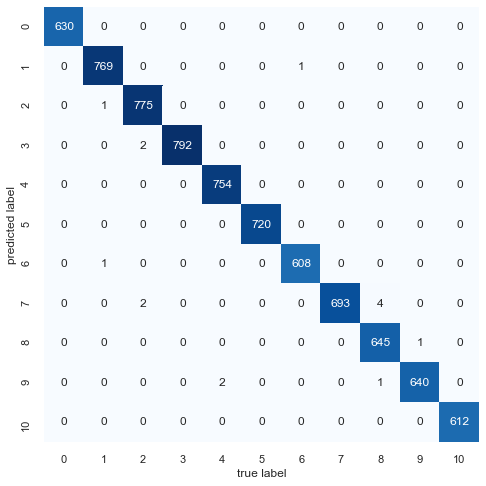

In [25]:
sns.set()
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test.values.argmax(axis=1), predict_test.values.argmax(axis=1))
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False, xticklabels=[0,1,2,3,4,5,6,7,8,9,10], yticklabels=[0,1,2,3,4,5,6,7,8,9, 10])
plt.xlabel('true label')
plt.ylabel('predicted label')

## 6.2 Validación (Näive Bayes)

In [26]:
report_NB = classification_report(y_train_1, predict_train_NB, [0,1,2,3,4,5,6,7,8,9,10])
print("Test Report for Näive Bayes train\n", report_NB)

report_NB = classification_report(y_test_1, predict_test_NB, [0,1,2,3,4,5,6,7,8,9,10])
print("Test Report for Näive Bayes test\n", report_NB)

Test Report for Näive Bayes train
               precision    recall  f1-score   support

           0       0.59      0.77      0.67      2637
           1       0.66      0.69      0.67      3129
           2       0.52      0.68      0.59      3073
           3       0.50      0.47      0.48      3009
           4       0.37      0.45      0.41      3111
           5       0.84      0.40      0.54      2718
           6       0.37      0.31      0.34      2541
           7       0.28      0.29      0.28      2751
           8       0.25      0.26      0.25      2695
           9       0.47      0.34      0.40      2575
          10       0.92      0.92      0.92      2370

    accuracy                           0.51     30609
   macro avg       0.52      0.51      0.50     30609
weighted avg       0.52      0.51      0.50     30609

Test Report for Näive Bayes test
               precision    recall  f1-score   support

           0       0.58      0.74      0.65       630
         

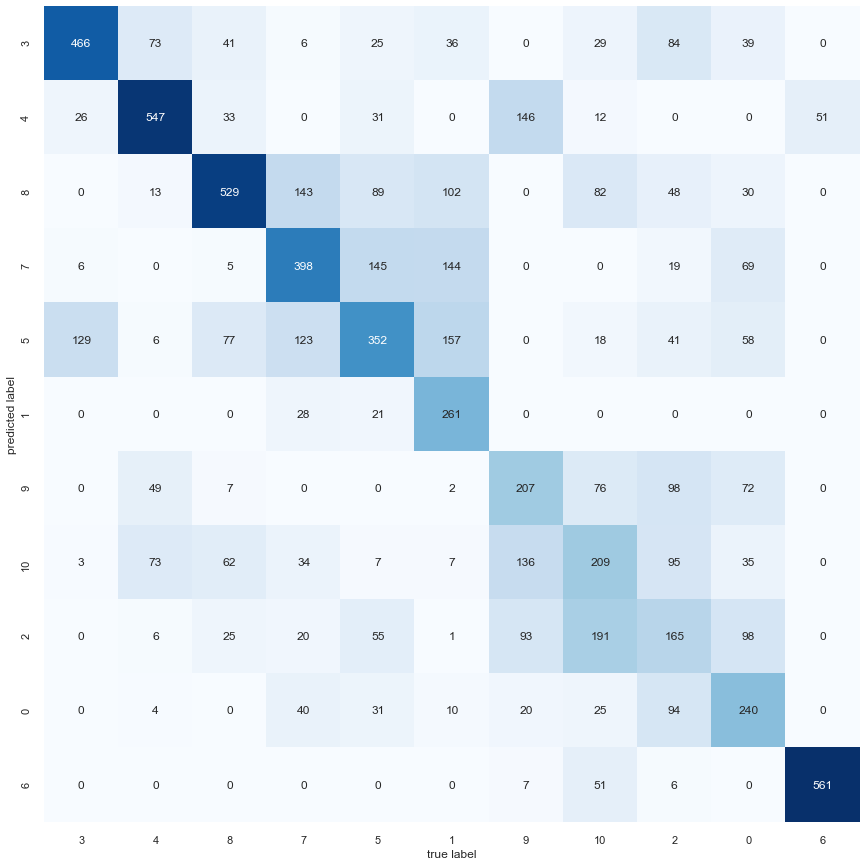

In [27]:
import seaborn as sns; sns.set()

plt.figure(figsize=(15,15))
mat = confusion_matrix(y_test_1, predict_test_NB)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=y_test_1.unique(),
            yticklabels=y_test_1.unique())
plt.xlabel('true label')
plt.ylabel('predicted label');

## 6.3 Validación (SVM)

In [28]:
report_svc = classification_report(y_train_1, predict_train_SVM, [0,1,2,3,4,5,6,7,8,9,10])
print("Test Report for SVC train with normalization\n", report_svc)

report_svc = classification_report(y_test_1, predict_test_SVM, [0,1,2,3,4,5,6,7,8,9,10])
print("Test Report for SVC test with normalization\n", report_svc)

Test Report for SVC train with normalization
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2637
           1       1.00      1.00      1.00      3129
           2       1.00      1.00      1.00      3073
           3       1.00      1.00      1.00      3009
           4       1.00      1.00      1.00      3111
           5       1.00      1.00      1.00      2718
           6       1.00      1.00      1.00      2541
           7       1.00      1.00      1.00      2751
           8       1.00      1.00      1.00      2695
           9       1.00      1.00      1.00      2575
          10       1.00      1.00      1.00      2370

    accuracy                           1.00     30609
   macro avg       1.00      1.00      1.00     30609
weighted avg       1.00      1.00      1.00     30609

Test Report for SVC test with normalization
               precision    recall  f1-score   support

           0       1.00      1.00      1.

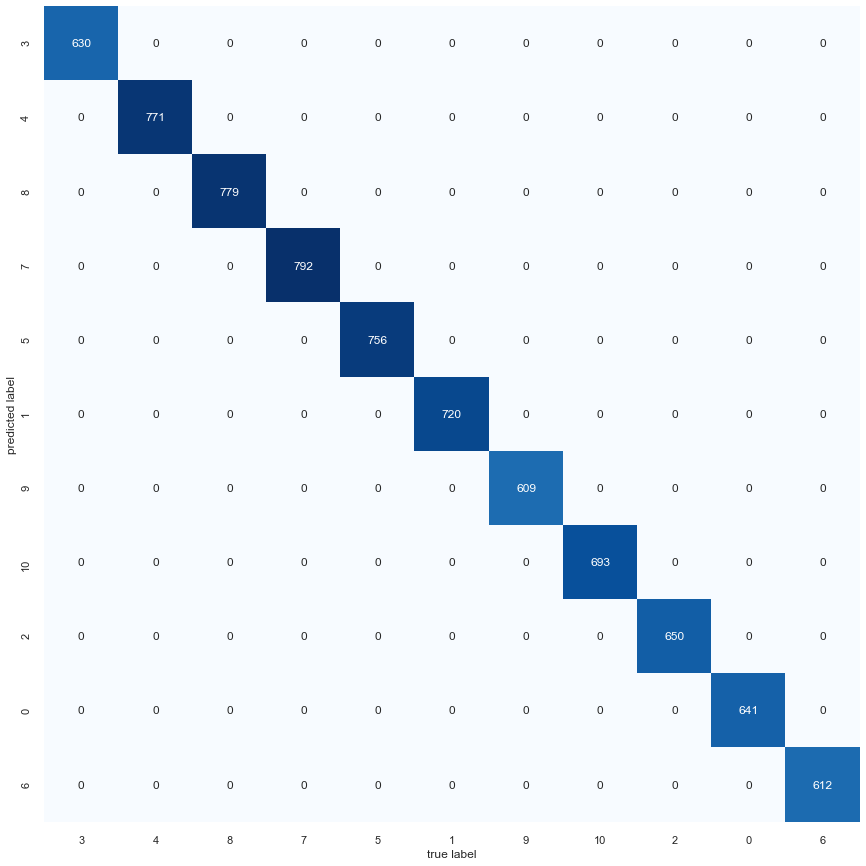

In [29]:
import seaborn as sns; sns.set()

plt.figure(figsize=(15,15))
mat = confusion_matrix(y_test_1, predict_test_SVM)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=y_test_1.unique(),
            yticklabels=y_test_1.unique())
plt.xlabel('true label')
plt.ylabel('predicted label');

## 6.4. Validación (Random Forest)

In [30]:
report_random_forest_clf_train = classification_report(y_train, y_predict_train)
report_random_forest_clf_test = classification_report(y_test, y_predict_test)
print("Test Report for train\n", report_random_forest_clf_train)
print("Test Report for test\n", report_random_forest_clf_test)

Test Report for train
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2637
           1       1.00      1.00      1.00      3129
           2       1.00      1.00      1.00      3073
           3       1.00      1.00      1.00      3009
           4       1.00      1.00      1.00      3111
           5       1.00      1.00      1.00      2718
           6       1.00      1.00      1.00      2541
           7       1.00      1.00      1.00      2751
           8       1.00      1.00      1.00      2695
           9       1.00      1.00      1.00      2575
          10       1.00      1.00      1.00      2370

   micro avg       1.00      1.00      1.00     30609
   macro avg       1.00      1.00      1.00     30609
weighted avg       1.00      1.00      1.00     30609
 samples avg       1.00      1.00      1.00     30609

Test Report for test
               precision    recall  f1-score   support

           0       1.00      1.00

Text(50.760000000000005, 0.5, 'predicted label')

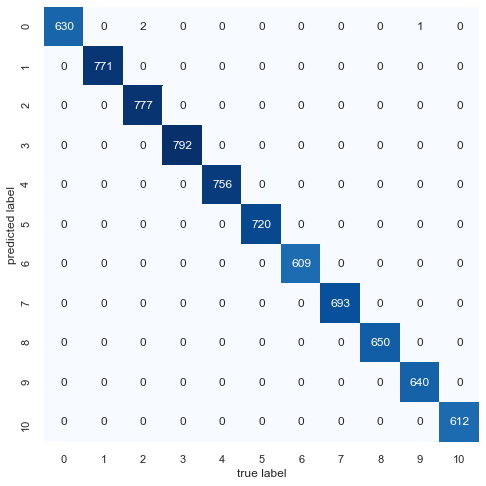

In [31]:
sns.set()
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test.values.argmax(axis=1), y_predict_test.argmax(axis=1))
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False, xticklabels=[0,1,2,3,4,5,6,7,8,9,10], yticklabels=[0,1,2,3,4,5,6,7,8,9,10])
plt.xlabel('true label')
plt.ylabel('predicted label')

## 6.5. Validación (GDC Classifier)

In [32]:
report_sgd_clf = classification_report(y_test_1, y_predict)
print("Test Report\n", report_sgd_clf)

Test Report
               precision    recall  f1-score   support

           0       1.00      0.94      0.97       630
           1       0.97      0.96      0.97       771
           2       0.92      0.95      0.93       779
           3       0.88      0.95      0.91       792
           4       0.75      0.46      0.57       756
           5       0.48      0.92      0.63       720
           6       0.99      0.96      0.97       609
           7       0.93      0.86      0.90       693
           8       0.98      0.28      0.44       650
           9       0.71      0.84      0.77       641
          10       1.00      1.00      1.00       612

    accuracy                           0.83      7653
   macro avg       0.87      0.83      0.82      7653
weighted avg       0.87      0.83      0.82      7653



Text(50.760000000000005, 0.5, 'predicted label')

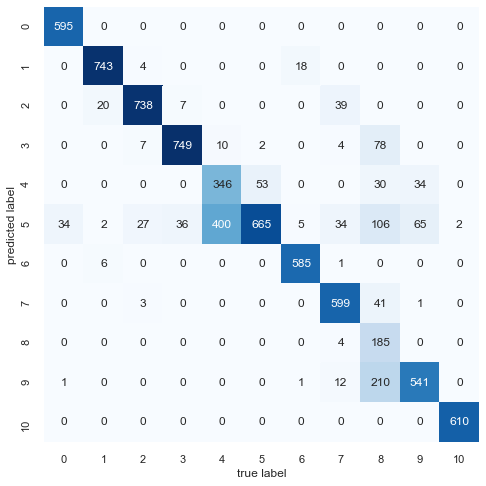

In [33]:
sns.set()
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test_1, y_predict)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False, xticklabels=[0,1,2,3,4,5,6,7,8,9,10], yticklabels=[0,1,2,3,4,5,6,7,8,9,10])
plt.xlabel('true label')
plt.ylabel('predicted label')

# 7. Conclusiones

* En este caso en particular, aumentar los datos nos permitió tener mejores resultados en la mayoría de los algoritmos probados, probablemente por un sobreajuste natural dado por la poca información suministrada.
* Se probaron cinco tipos diferentes de algoritmos con resultados variados, logrando en varios de ellos clasificaciones casi perfectas. Los de peor rendimiento fueron Bayes y el GDC Classifier. Mientras que los de mejor rendimiento fueron Random Forest, SVM, y el MLP.
* Por simplicidad a la hora de ser exportado (para implementaciones futuras), consideramos que el SVM y el random forest son los de mejor rendimiento, aunque no descartamos la viabilidad de uso de la red neuronal.
